# Probabilistic Methods (Discrete)

What is it? 
- Focusing on how to identify anomalies in our discrete variables

Why do we care?
- Allows us to find items, events, or observations which are significantly different from the remaining data and determine whether or not they belong

How do we do it? 

- **count**: the number of times each unique value appears in the dataset
- **frequencies**: the number of times each unique value appears in the dataset as a percentage of the total
- **conditional probability**: the likelihood of an event or outcome occurring, based on the occurrence of a previous event or outcome


Examples:

- count: How many times we see an ip address in the dataset
- frequncy: What is probability of ip address showing up in the dataset
- conditional probability: Given an ip address, what is prob of a particular status (e.g authentication failure)

### Scenario

Use codeup's access logs to determine if anyone is accessing the curriculum when they shouldn't be. This data is from codeup's first data science cohort, Ada. Each row is one request to the server.

In [1]:
#do the data things!
import numpy as np
import pandas as pd

#visualize
import matplotlib.pyplot as plt
import seaborn as sns

#my sql creds
import env

## Acquire

<div class="alert alert-block alert-info">
<b>NOTE: </b> 
    
`pd.read_sql` operates differently in the newest update
    
New process: 
1. import `text` and `create_engine` from `sqlalchemy`
2. create url (same way as before)
3. create engine with url and connect
4. specify query as text
5. send query and engine into `pd.read_sql`
    
</div>

1. import text and create_engine from sqlalchemy

In [2]:
from sqlalchemy import text, create_engine

2. create url (same way as before)


In [5]:
url = env.get_db_url('logs')

3. create engine with url and connect

In [8]:
conn = create_engine(url).connect()

4. specify query as text

In [9]:
query = text('show tables')

5. send query and connection into pd.read_sql

In [10]:
pd.read_sql(query, conn)

,Tables_in_logs
0,api_access


In [11]:
pd.read_sql('show tables', url)

,Tables_in_logs
0,api_access


#### get data

In [13]:
df = pd.read_sql('select * from api_access', url)

In [14]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   entry   13974 non-null  object
dtypes: object(1)
memory usage: 109.3+ KB


### Prepare

the data needs to be parsed out so we can see each piece of the access log

In [21]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [22]:
#accessing one row
df.entry[0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [30]:
#separating the elements in one row
df.entry[0].split()

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [25]:
#save it
parts = df.entry[0].split()
parts

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [34]:
df.entry.str.split(expand=True).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,97.105.19.58,-,-,[16/Apr/2019:19:34:42,+0000],"""GET",/api/v1/sales?page=81,"HTTP/1.1""",200,512495,...,None,None,None,None,None,None,None,None,None,None
1,97.105.19.58,-,-,[16/Apr/2019:19:34:42,+0000],"""GET",/api/v1/items,"HTTP/1.1""",200,3561,...,None,None,None,None,None,None,None,None,None,None
2,97.105.19.58,-,-,[16/Apr/2019:19:34:44,+0000],"""GET",/api/v1/sales?page=82,"HTTP/1.1""",200,510103,...,None,None,None,None,None,None,None,None,None,None
3,97.105.19.58,-,-,[16/Apr/2019:19:34:46,+0000],"""GET",/api/v1/sales?page=83,"HTTP/1.1""",200,510003,...,None,None,None,None,None,None,None,None,None,None
4,97.105.19.58,-,-,[16/Apr/2019:19:34:48,+0000],"""GET",/api/v1/sales?page=84,"HTTP/1.1""",200,511963,...,None,None,None,None,None,None,None,None,None,None


In [35]:
#create dictionary to hold results
output= {}

In [38]:
#pull out ip address
output['ip'] = parts[0]

In [39]:
output

{'ip': '97.105.19.58'}

In [40]:
parts

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [44]:
df.entry.str.split(expand=True)[1].unique()

array(['-'], dtype=object)

In [45]:
df.entry.str.split(expand=True)[2].unique()

array(['-'], dtype=object)

In [52]:
#pull out time
output['time'] = parts[3][1:].replace(":",' ', 1)

In [53]:
output

{'ip': '97.105.19.58', 'time': '16/Apr/2019 19:34:42'}

In [54]:
parts

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [57]:
df.entry.str.split(expand=True)[4].unique()

array(['+0000]'], dtype=object)

In [58]:
#pull out request method
df.entry.str.split(expand=True)[5].unique()

array(['"GET'], dtype=object)

In [62]:
output['request_method'] = parts[5].strip('"')

In [63]:
output

{'ip': '97.105.19.58', 'time': '16/Apr/2019 19:34:42', 'request_method': 'GET'}

In [64]:
parts

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [66]:
#pull out request path
output['request_path'] = parts[6]

In [67]:
output

{'ip': '97.105.19.58',
 'time': '16/Apr/2019 19:34:42',
 'request_method': 'GET',
 'request_path': '/api/v1/sales?page=81'}

In [70]:
#pull our http version
output['http_version'] = parts[7][:-1]

In [71]:
output

{'ip': '97.105.19.58',
 'time': '16/Apr/2019 19:34:42',
 'request_method': 'GET',
 'request_path': '/api/v1/sales?page=81',
 'http_version': 'HTTP/1.1'}

In [72]:
parts

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [74]:
#pull out status code
output['status_code'] = parts[8]

In [75]:
output

{'ip': '97.105.19.58',
 'time': '16/Apr/2019 19:34:42',
 'request_method': 'GET',
 'request_path': '/api/v1/sales?page=81',
 'http_version': 'HTTP/1.1',
 'status_code': '200'}

In [78]:
# pull out size
output['size'] = parts[9]

In [79]:
output

{'ip': '97.105.19.58',
 'time': '16/Apr/2019 19:34:42',
 'request_method': 'GET',
 'request_path': '/api/v1/sales?page=81',
 'http_version': 'HTTP/1.1',
 'status_code': '200',
 'size': '512495'}

In [90]:
for col in df.entry.str.split(expand=True).iloc[:,11:].columns:
    print(df.entry.str.split(expand=True)[col].unique())

['"python-requests/2.21.0"' '"Mozilla/5.0' '"Slackbot-LinkExpanding'
 '"Slackbot' '"python-requests/2.20.1"' '"Python-urllib/3.7"']
[None '(Macintosh;' '1.0']
[None 'Intel' '(+https://api.slack.com/robots)"']
[None 'Mac']
[None 'OS']
[None 'X']
[None '10_14_4)' '10_14_3)' '10.14;']
[None 'AppleWebKit/537.36' 'rv:66.0)']
[None '(KHTML,' 'Gecko/20100101']
[None 'like' 'Firefox/66.0"']
[None 'Gecko)']
[None 'Chrome/73.0.3683.103' 'Chrome/72.0.3626.121']
[None 'Safari/537.36"']


In [96]:
#combine request agents together
' '.join(parts[11:]).strip('"')

'python-requests/2.21.0'

In [97]:
parts

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [101]:
# # function to deal with parsing one entry in our log data
#this function works on one string
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).strip('"')
    return pd.Series(output)

In [103]:
#apply string function to every element in a series
df = df.entry.apply(parse_log_entry)

In [104]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13969,97.105.19.58,17/Apr/2019 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
13970,97.105.19.58,17/Apr/2019 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
13971,97.105.19.58,17/Apr/2019 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0
13972,97.105.19.58,17/Apr/2019 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0


### For the sake of lesson, adding some anomalies

In [105]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", 
     '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

In [106]:
df = pd.concat([df,new])

In [107]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13973,97.105.19.58,17/Apr/2019 12:55:14,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0
0,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0
1,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0


In [110]:
df = df.reset_index(drop=True)

In [111]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13973,97.105.19.58,17/Apr/2019 12:55:14,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0
13974,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0
13975,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
13976,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0


#### making new size column based mb

In [116]:
#divide by 1024 twice
df['size_mb'] = df['size'] / 1024 / 1024

In [117]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


## Detecting Anomalies in Discrete Variables

- count
- frequency
- visualize
- conditional probability

###  count

let's see how many times each ip address comes up in our dataset

In [120]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64

In [124]:
#save it into a dataframe
ip_df1 = df.ip.value_counts().reset_index().rename(columns={'index':'ip','ip':'cnt'})
ip_df1

,ip,cnt
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21
5,24.26.242.9,21
6,35.175.171.137,2
7,52.87.230.102,2
8,70.121.214.34,2
9,52.90.165.200,1


### frequency

let's now calculate the probabity for each ip 

ip_prob = count for each ip / total count in the dataframe

In [125]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [133]:
#divide
df.ip.value_counts() / len(df)

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
24.26.242.9       0.001502
35.175.171.137    0.000143
52.87.230.102     0.000143
70.121.214.34     0.000143
52.90.165.200     0.000072
95.31.16.121      0.000072
95.31.18.119      0.000072
45.23.250.16      0.000072
52.91.30.150      0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
54.172.14.223     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
54.145.52.184     0.000072
34.229.70.250     0.000072
97.105.15.120     0.000072
Name: ip, dtype: float64

In [136]:
#best function
df.ip.value_counts(normalize=True)

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
24.26.242.9       0.001502
35.175.171.137    0.000143
52.87.230.102     0.000143
70.121.214.34     0.000143
52.90.165.200     0.000072
95.31.16.121      0.000072
95.31.18.119      0.000072
45.23.250.16      0.000072
52.91.30.150      0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
54.172.14.223     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
54.145.52.184     0.000072
34.229.70.250     0.000072
97.105.15.120     0.000072
Name: ip, dtype: float64

In [141]:
#save it to a df
ip_df2 = df.ip.value_counts(normalize=True).reset_index().rename(columns={'index':'ip','ip':'percent'})
ip_df2.head()

,ip,percent
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,68.201.219.223,0.001502


#### merge em

In [146]:
ip_df = pd.merge(ip_df1, ip_df2, how='inner', on='ip')
ip_df.head()

,ip,cnt,percent
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


### visualize them

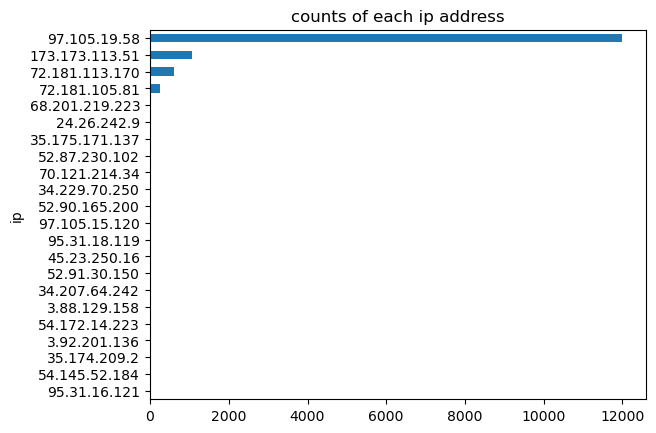

In [157]:
ip_df.set_index('ip').cnt.sort_values().plot.barh()
plt.title('counts of each ip address')
plt.show()

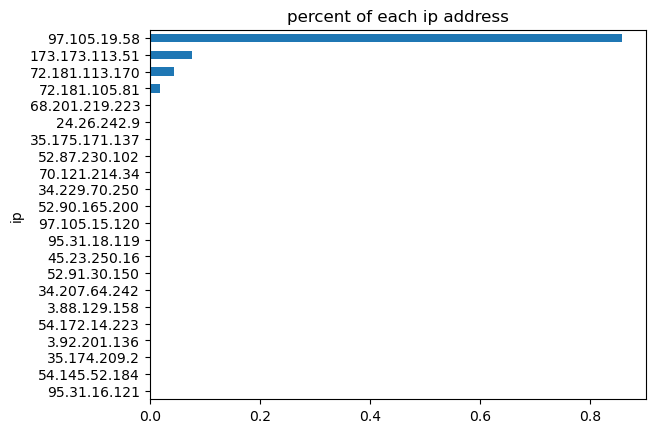

In [158]:
ip_df.set_index('ip').percent.sort_values().plot.barh()

plt.title('percent of each ip address')
plt.show()

### conditional probability

what is the probability of event A happening given that event B has happened? 

$P(A|B) = {P(A \cap B) \over P(B)}$

aka: the probability of both event A and event B happening divided by the probability of only B happening

#### our access logs

What is probability of a certain status code given an IP address?

HTTP Status Codes

    200: ok
    3xx: redirects
    4xx: client level errors -- the requester did something wrong
    5xx: server level errors -- the server did something wrong


In [161]:
df.status_code

0        200
1        200
2        200
3        200
4        200
        ... 
13973    200
13974    200
13975    301
13976    301
13977    200
Name: status_code, Length: 13978, dtype: object

In [249]:
#get the counts for ip and status_code
df.groupby(['ip','status_code']).size()

ip              status_code
173.173.113.51  200             1059
24.26.242.9     200               21
3.88.129.158    200                1
3.92.201.136    200                1
34.207.64.242   200                1
34.229.70.250   200                1
35.174.209.2    200                1
35.175.171.137  200                2
45.23.250.16    200                1
52.87.230.102   200                2
52.90.165.200   200                1
52.91.30.150    200                1
54.145.52.184   200                1
54.172.14.223   200                1
68.201.219.223  200               21
70.121.214.34   200                2
72.181.105.81   200              246
72.181.113.170  200              611
                499                2
95.31.16.121    301                1
95.31.18.119    200                1
97.105.15.120   301                1
97.105.19.58    200            11985
                499               14
dtype: int64

In [167]:
#probability of ip and status code
p_a_and_b = df.groupby(['ip','status_code']).size() / len(df)
p_a_and_b

ip              status_code
173.173.113.51  200            0.075762
24.26.242.9     200            0.001502
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001502
70.121.214.34   200            0.000143
72.181.105.81   200            0.017599
72.181.113.170  200            0.043712
                499            0.000143
95.31.16.121    301            0.000072
95.31.18.119    200            0.000072
97.105.15.120   301            0.000072
97.105.19.58    200            0.857419
                499            0.001002
dtype: float

In [247]:
p_a_and_b.sort_index() / 

(df.ip.value_counts() / len(df)).sort_index()

173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001502
70.121.214.34     0.000143
72.181.105.81     0.017599
72.181.113.170    0.043855
95.31.16.121      0.000072
95.31.18.119      0.000072
97.105.15.120     0.000072
97.105.19.58      0.858420
Name: ip, dtype: float64

In [197]:
#probability of ip
p_b = df.groupby('ip').size() / len(df)
p_b

ip
173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001502
70.121.214.34     0.000143
72.181.105.81     0.017599
72.181.113.170    0.043855
95.31.16.121      0.000072
95.31.18.119      0.000072
97.105.15.120     0.000072
97.105.19.58      0.858420
dtype: float64

In [200]:
# Given a particular ip, what is probability of a certain status code
p_a_and_b / p_b

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
95.31.16.121    301            1.000000
95.31.18.119    200            1.000000
97.105.15.120   301            1.000000
97.105.19.58    200            0.998833
                499            0.001167
dtype: float

In [250]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = df.groupby('ip').status_code.value_counts(normalize=True).rename('prob').reset_index()
status_given_ip

,ip,status_code,prob
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


#### Cases where the probability is < 100% -- this means that multiple different status codes were encountered from the given ip address

In [251]:
status_given_ip [status_given_ip.prob < 1]

,ip,status_code,prob
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


#### Status codes other than 200. 200 is the most common response code in our dataset by far.

In [252]:
status_given_ip [status_given_ip.status_code != '200']

,ip,status_code,prob
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [233]:
df [df.ip == '72.181.113.170']

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
12395,72.181.113.170,17/Apr/2019 02:12:07,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
12577,72.181.113.170,17/Apr/2019 02:18:07,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040
12578,72.181.113.170,17/Apr/2019 02:18:07,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154
12591,72.181.113.170,17/Apr/2019 02:48:27,GET,/api/v1/sales,HTTP/1.1,200,493905,python-requests/2.21.0,0.471025
12592,72.181.113.170,17/Apr/2019 02:48:28,GET,/api/v1/sales?page=2,HTTP/1.1,200,494819,python-requests/2.21.0,0.471896
...,...,...,...,...,...,...,...,...,...
13421,72.181.113.170,17/Apr/2019 03:52:00,GET,/api/v1/sales?page=179,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
13422,72.181.113.170,17/Apr/2019 03:52:02,GET,/api/v1/sales?page=180,HTTP/1.1,200,510788,python-requests/2.21.0,0.487125
13423,72.181.113.170,17/Apr/2019 03:52:04,GET,/api/v1/sales?page=181,HTTP/1.1,200,510317,python-requests/2.21.0,0.486676
13424,72.181.113.170,17/Apr/2019 03:52:06,GET,/api/v1/sales?page=182,HTTP/1.1,200,510540,python-requests/2.21.0,0.486889
